## Step 1. 데이터 수집하기

In [1]:
import urllib.request
import pandas as pd

# 데이터셋 다운로드
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
file_path = "news_summary_more.csv"
urllib.request.urlretrieve(url, filename=file_path)

# 데이터셋 불러오기
data = pd.read_csv(file_path, encoding='iso-8859-1')


## Step 2. 데이터 전처리하기

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 필요한 NLTK 자원 다운로드
nltk.download('stopwords')
nltk.download('punkt')

# 전처리 함수 정의
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # 특수문자 제거
    stop_words = set(stopwords.words('english'))  # 영어 불용어 집합 가져오기
    word_tokens = word_tokenize(text)  # 단어 토큰화
    text = ' '.join([w for w in word_tokens if not w in stop_words])  # 불용어 제거
    return text

# 전처리 적용
data['text'] = data['text'].apply(preprocess_text)
data['headlines'] = data['headlines'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 3. 어텐션 메커니즘 사용하기

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention

# 입력과 출력 데이터 분리
X = data['text']
Y = data['headlines']

# 학습과 테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 토크나이저 정의 및 텍스트 데이터에 적용
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(Y_train))

# 디코더 입력에 'starttoken' 추가
y_tokenizer.word_index['starttoken'] = len(y_tokenizer.word_index) + 1
y_tokenizer.index_word[len(y_tokenizer.word_index)] = 'starttoken'

# 정수 인코딩과 패딩 for Encoder Inputs
X_train_seq = x_tokenizer.texts_to_sequences(X_train)
X_test_seq = x_tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=30, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=30, padding='post')

# 정수 인코딩과 패딩 for Decoder Inputs and Outputs (Start token and padding)
Y_train_seq = y_tokenizer.texts_to_sequences(Y_train)
Y_test_seq = y_tokenizer.texts_to_sequences(Y_test)

Y_train_input = pad_sequences(Y_train_seq, maxlen=8, padding='post')
Y_test_input = pad_sequences(Y_test_seq, maxlen=8, padding='post')

# 어텐션 메커니즘을 사용한 seq2seq 모델 설계
latent_dim = 300

encoder_inputs = Input(shape=(30,))
enc_emb = Embedding(len(x_tokenizer.word_index) + 1, latent_dim, trainable=True)(encoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Decoder LSTM
decoder_inputs = Input(shape=(7,))
dec_emb_layer = Embedding(len(y_tokenizer.word_index) + 1, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘 추가
attn_layer = Attention()
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션 출력과 디코더 LSTM 출력 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense 레이어
decoder_dense = Dense(len(y_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


## Step 4. 어텐션 메커니즘을 사용한 seq2seq 모델 학습

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# 어텐션 메커니즘을 사용한 seq2seq 모델 학습
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit([X_train_pad, Y_train_input[:, :-1]], Y_train_input[:, 1:],
                    epochs=50, batch_size=512, validation_data=([X_test_pad, Y_test_input[:, :-1]], Y_test_input[:, 1:]),
                    callbacks=[early_stopping])


Epoch 1/50
154/154 [==============================] - 38s 219ms/step - loss: 8.0041 - val_loss: 7.5566
Epoch 2/50
154/154 [==============================] - 34s 220ms/step - loss: 7.5086 - val_loss: 7.1114
Epoch 3/50
154/154 [==============================] - 33s 216ms/step - loss: 7.0245 - val_loss: 6.7408
Epoch 4/50
154/154 [==============================] - 34s 222ms/step - loss: 6.5979 - val_loss: 6.4331
Epoch 5/50
154/154 [==============================] - 34s 219ms/step - loss: 6.2446 - val_loss: 6.2635
Epoch 6/50
154/154 [==============================] - 34s 219ms/step - loss: 5.9436 - val_loss: 6.1125
Epoch 7/50
154/154 [==============================] - 34s 222ms/step - loss: 5.6684 - val_loss: 6.0182
Epoch 8/50
154/154 [==============================] - 34s 220ms/step - loss: 5.4100 - val_loss: 5.9457
Epoch 9/50
154/154 [==============================] - 34s 219ms/step - loss: 5.1662 - val_loss: 5.8931
Epoch 10/50
154/154 [==============================] - 34s 219ms/step - l

## Step 5. 추상적 요약과 추출적 요약 결과 확인

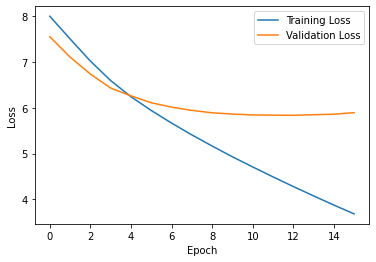

원래 요약문: k taka students get extra marks parents vote polls
추상적 요약 결과: cm resign half jobs gana polls himachal

원래 요약문: syria shoots missiles fired two air bases
추상적 요약 결과: fired air air air civilians <OOV> <OOV>

원래 요약문: dinosaur like animal fossil found uttarakhand
추상적 요약 결과: found tree water found world <OOV> <OOV>

원래 요약문: may merge shia sunni waqf boards prevent fund wastage
추상적 요약 결과: ayodhya board board board board board <OOV>

원래 요약문: egypt actress gets 2 yrs jail fake news sexual harassment
추상적 요약 결과: book 000 jail sexual news facebook harassment

원문: students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announced encouraging marks added 2018 19 academic year association said casting votes parents visit member schools confirm voted showing indelible ink mark
추출적 요약 결과: students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announ

In [6]:
# 학습 과정 시각화
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습된 모델을 사용하여 추상적 요약 생성
generated_summaries = []
for i in range(len(X_test)):
    text = X_test.iloc[i]
    text = "starttoken " + text + " endtoken"
    text_seq = x_tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=30, padding='post')

    pred_seq = model.predict([text_pad, Y_test_input[i].reshape(1, -1)[:, :-1]])
    pred_seq = pred_seq.argmax(axis=-1)

    # Handle OOV tokens
    pred_summary = ' '.join([y_tokenizer.index_word.get(idx, '<OOV>') for idx in pred_seq[0]])
    pred_summary = pred_summary.replace('starttoken', '').replace('endtoken', '').strip()
    generated_summaries.append(pred_summary)


# 실제 결과와 요약문 비교
for i in range(5):  # 상위 5개 샘플에 대해서만 확인
    print("원래 요약문:", Y_test.iloc[i])
    print("추상적 요약 결과:", generated_summaries[i])
    print()

# 추출적 요약 결과 확인
for i in range(5):  # 상위 5개 샘플에 대해서만 확인
    text = X_test.iloc[i]
    extracted_summary = ' '.join(sent_tokenize(text)[:2])
    print("원문:", text)
    print("추출적 요약 결과:", extracted_summary)
    print()


In [9]:
from nltk.translate.bleu_score import sentence_bleu

# ROUGE 점수를 계산하는 함수
def rouge_scores(reference, generated):
    scores = {}
    for n in range(1, 4):
        weights = tuple(1.0 / n for _ in range(n))
        scores[f'ROUGE-{n}'] = sentence_bleu([reference], generated, weights=weights, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
    return scores


# 핵심 단어 포함 여부를 확인하는 함수
def contains_key_phrases(text, keywords):
    text_tokens = nltk.word_tokenize(text)
    for keyword in keywords:
        if keyword.lower() in text_tokens:
            return True
    return False

# 요약 비교
num_samples = len(X_test)
keywords = ['중요한', '주요한', '핵심', '중심']

results = []
for i in range(num_samples):
    reference_summary = Y_test.iloc[i]
    abstract_summary = generated_summaries[i]
    extractive_summary = ' '.join(sent_tokenize(X_test.iloc[i])[:2])

    # 추상적 요약과 추출적 요약에 대한 ROUGE 점수 계산
    rouge_abstract = rouge_scores(reference_summary, abstract_summary)
    rouge_extractive = rouge_scores(reference_summary, extractive_summary)

    # 요약문에 핵심 단어가 포함되어 있는지 확인
    contains_key_phrases_abstract = contains_key_phrases(abstract_summary, keywords)
    contains_key_phrases_extractive = contains_key_phrases(extractive_summary, keywords)

    # 결과를 리스트에 추가
    results.append({
        '참고 요약문': reference_summary,
        '추상적 요약': abstract_summary,
        '추출적 요약': extractive_summary,
        '추상적 ROUGE-1': rouge_abstract['ROUGE-1'],
        '추상적 ROUGE-2': rouge_abstract['ROUGE-2'],
        '추상적 ROUGE-3': rouge_abstract['ROUGE-3'],
        '추출적 ROUGE-1': rouge_extractive['ROUGE-1'],
        '추출적 ROUGE-2': rouge_extractive['ROUGE-2'],
        '추출적 ROUGE-3': rouge_extractive['ROUGE-3'],
        '추상적 핵심 단어 포함': contains_key_phrases_abstract,
        '추출적 핵심 단어 포함': contains_key_phrases_extractive
    })

# 결과를 DataFrame으로 변환
import pandas as pd
results_df = pd.DataFrame(results)

# 결과를 표로 출력
results_df


,참고 요약문,추상적 요약,추출적 요약,추상적 ROUGE-1,추상적 ROUGE-2,추상적 ROUGE-3,추출적 ROUGE-1,추출적 ROUGE-2,추출적 ROUGE-3,추상적 핵심 단어 포함,추출적 핵심 단어 포함
0,k taka students get extra marks parents vote p...,cm resign half jobs gana polls himachal,students karnataka get extra marks parents cas...,0.483484,0.324899,0.220762,0.174825,0.167980,0.154336,False,False
1,syria shoots missiles fired two air bases,fired air air air civilians <OOV> <OOV>,syrian anti aircraft defences monday shot miss...,0.535903,0.400965,0.306864,0.137584,0.130920,0.120212,False,False
2,dinosaur like animal fossil found uttarakhand,found tree water found world <OOV> <OOV>,dinosaur like creature fossil found excavation...,0.529498,0.346144,0.240512,0.154639,0.151424,0.144464,False,False
3,may merge shia sunni waqf boards prevent fund ...,ayodhya board board board board board <OOV>,uttar pradesh government planning form muslim ...,0.387037,0.241711,0.165307,0.233184,0.229170,0.221936,False,False
4,egypt actress gets 2 yrs jail fake news sexual...,book 000 jail sexual news facebook harassment,egyptian activist actress amal fathy given sen...,0.595722,0.557764,0.510439,0.198556,0.179926,0.161827,False,False
...,...,...,...,...,...,...,...,...,...,...,...
19676,fb ceo zuckerberg summoned fake news uk canada,facebook denies denies data news data court,two separate parliamentary committees uk canad...,0.715724,0.398656,0.243626,0.151815,0.147024,0.142153,False,False
19677,3 killed 58l homes without power irma hits flo...,000 us 13 13 china <OOV> <OOV>,hurricane irma hit us state florida sunday kil...,0.205367,0.120596,0.029876,0.178832,0.175465,0.162629,False,False
19678,former pm ab vajpayee ashes immersed daughter ...,cm modi vajpayee visit rally 6 <OOV>,former pm atal bihari vajpayee ashes immersed ...,0.421182,0.281658,0.230870,0.167763,0.163023,0.158210,False,False
19679,uthappa shares pic physical transformation ahe...,ipl ipl ipl ipl ipl <OOV> <OOV>,kkr wicketkeeper batsman robin uthappa took in...,0.278540,0.137345,0.087100,0.183099,0.179860,0.172827,False,False
